In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas
import math

# make this point to the file with the clean tweets
DATAFILE = "data_clean_new.csv"
DATAFILE_ORIGINAL = "data_original.csv"

In [2]:
# read the csv
data = pandas.read_csv(DATAFILE, index_col=0)
data_original = pandas.read_csv(DATAFILE_ORIGINAL, index_col=0)

# NAs = data["is_retweet"].isna()
# rt_present = []
# for i in range(len(data)):
#     if NAs[i]:
#         rt_present.append('rt' in data["text"])

# # if no data is given, assume that 'rt' tells us
# # if a tweet is a retweet or not
# data["is_retweet"][data["is_retweet"].isna()] = rt_present

# # verify if all the retweets have the "rt" string
# all_have_rt = True
# # verity if all the tweets with "rt" are retweets
# all_are_retweets = True
# for i in range(len(data)):
#     if data["is_retweet"][i]:
#         all_have_rt &= "'rt'" in data["text"][i]
#     if "'rt'" in data["text"][i]:
#         all_are_retweets = all_are_retweets and data["is_retweet"][i]
# if all_have_rt:
#     print(f"All retweets have the 'rt' string")
# if all_are_retweets:
#     print(f"All 'rt' tweets are retweets")

In [3]:
# get all the tweets
# as of now, they are still strings, the string representation of the list
tweets = []
for tweet in data["text"]:
    tweets.append(eval(tweet))

# get the unique set of existing words and count those words
# check the most common ones
words = {}
total_words = 0
for tweet in tweets:
    for word in tweet:
        total_words += 1
        if word in words.keys():
            words[word] += 1
        else:
            words[word] = 1
print(f"We have {total_words} words, of which {len(words.keys())} are unique")
words_tuples = [(word, words[word]) for word in words.keys()]
words_tuples.sort(reverse=True, key=lambda t: t[1])

We have 53640 words, of which 4819 are unique


Text(0.5, 1.0, 'Most common tweet words')

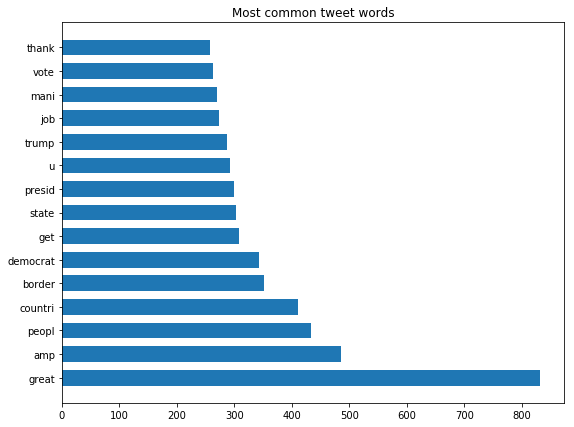

In [4]:
# plot a histogram of the N most common words
fig, ax = plt.subplots(figsize=(9,7))
N = 15
heights = [tup[1] for tup in words_tuples[:N]]
words = [tup[0] for tup in words_tuples[:N]]
indices = list(range(1, 3*N+1, 3))
bar_width = 2

ax.barh(indices, heights, bar_width)
ax.set_yticks(indices)
ax.set_yticklabels(words)
ax.set_title("Most common tweet words")

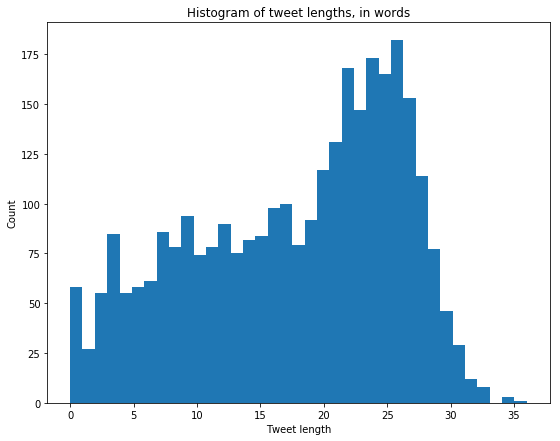

In [5]:
# plot a histogram of the number of words per tweet
lens = list(map(len, tweets))
maxsize = max(lens)

fig, ax = plt.subplots(figsize=(9,7))
ax.hist(lens, bins=maxsize+1);
ax.set_title("Histogram of tweet lengths, in words");
ax.set_xlabel("Tweet length");
ax.set_ylabel("Count");

There are 1744 words that only show up once


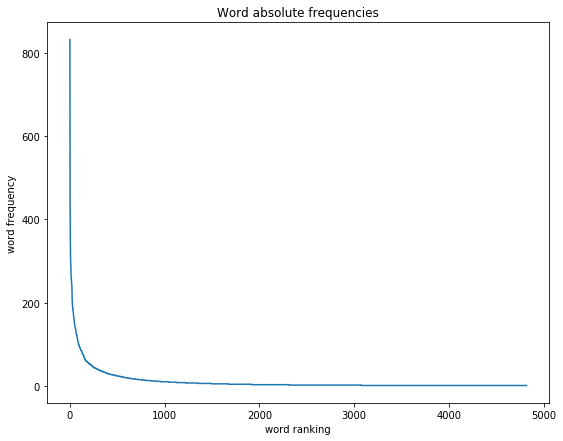

In [6]:
# check the curve of the frequencies
fig, ax = plt.subplots(figsize=(9,7))
freqs = [t[1] for t in words_tuples]
ax.plot(freqs)
ax.set_title("Word absolute frequencies")
ax.set_xlabel("word ranking")
ax.set_ylabel("word frequency")

first_one = freqs.index(1)
print(f"There are {len(freqs)-first_one} words that only show up once")

In [7]:
# check how many words make up some quantiles of the total number of words
quantiles = [0.5, 0.75, 0.9, 0.95]
# counts[i] is a pair (n, per) meaning that n words is the minimum number of
# words needed to make up for quantiles[i]% of all the words
counts = []
for q in quantiles:
    if counts:
        i = counts[-1][0]
        per = counts[-1][1]
    else:
        i = 0
        per = 0
    while per < q:
        i += 1
        per += words_tuples[i][1]/total_words
    counts.append((i, per))
for count in counts:
    print(f"{count[0]} words make up for {round(100*count[1],2)}% of all the words used")

248 words make up for 50.0% of all the words used
783 words make up for 75.01% of all the words used
1898 words make up for 90.01% of all the words used
3021 words make up for 95.0% of all the words used


['great', 'amp', 'peopl', 'countri', 'border', 'democrat', 'get', 'state', 'presid', 'u']


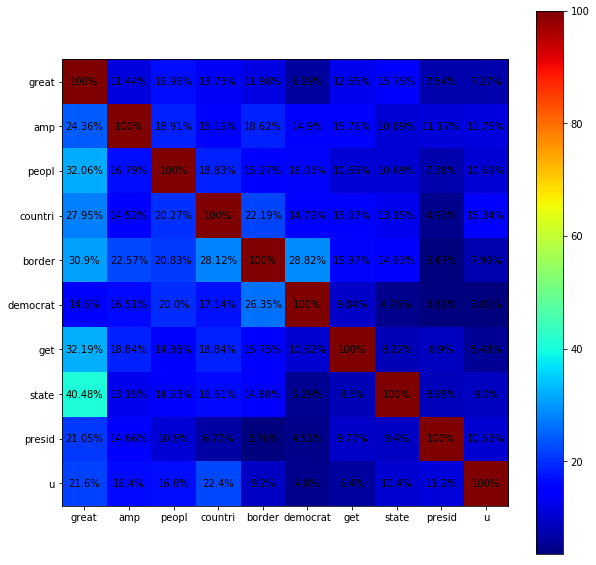

In [8]:
# take the N most common words and check how many times they show up together
N = 10
topN_words = [t[0] for t in words_tuples[:N]]
print(topN_words)
# matrix[i][j] has the percentage of tweets containing word i that also contained word j
matrix = [[0 for i in range(N)] for j in range(N)]
for j in range(N):
    base_word = topN_words[j]
    for tweet in tweets:
        if base_word in tweet:
            for i in range(j, N):
                scnd_word = topN_words[i]
                if scnd_word in tweet:
                    matrix[i][j] += 1
for j in range(N):
    for i in range(j):
        matrix[i][j] = matrix[j][i]
# at this step matrix[i][j] = matrix[j][i] only has, in (i,j), the number of times words i and j come up together
for i in range(N):
    for j in range(i+1, N):
        matrix[i][j] = round(matrix[i][j]/matrix[i][i]*100, 2)
    for j in range(i):
        matrix[i][j] = round(matrix[i][j]/matrix[i][i]*100, 2)
for i in range(N):
    matrix[i][i] = 100

# plot the matrix, code from
# https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
fig = plt.figure(figsize=(10,10))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(matrix), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = N, N

for x in range(width):
    for y in range(height):
        ax.annotate(f"{matrix[x][y]}%", xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
plt.xticks(range(width), topN_words)
plt.yticks(range(height), topN_words)
None # prevent annoying extra output

In the above "confusion matrix" we can see, for example, that $32.39\%$ of all the tweets containing the word _people_ also contained the word _great_ (as we can confirm with the next snippet) but only $17.49\%$ of the tweets with the word _great_ contained the word _people_.

In [9]:
count = 0
hits = 0
for tweet in tweets:
    if "peopl" in tweet:
        count += 1
        if "great" in tweet:
            hits += 1
print(hits/count)

0.32061068702290074


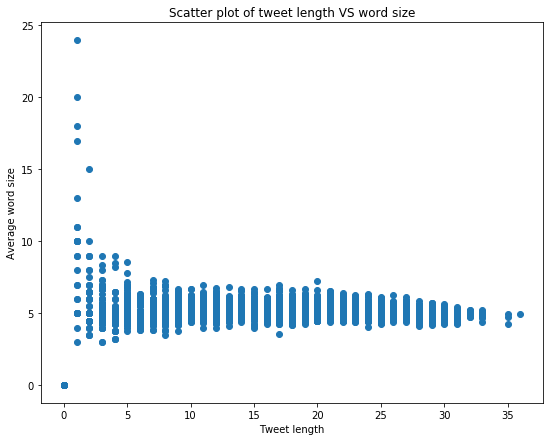

In [10]:
# check the relationship between amount of words and avg length of the words
lens = list(map(len, tweets))
avg_word_length = [sum([len(word) for word in tweets[i]])/lens[i] if lens[i] > 0 else 0 for i in range(len(lens))]

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(lens, avg_word_length)
ax.set_title("Scatter plot of tweet length VS word size");
ax.set_xlabel("Tweet length");
ax.set_ylabel("Average word size");

In [11]:
# Note that some of the tweets with only 1 long word
# actually look like they were hashtags
for tweet in tweets:
    if len(tweet) == 1 and len(tweet[0]) > 10:
        print(tweet)

['armynavygam']
['hurricaneflor']
['pledgetoamericaswork']
['memorialday']
['peaceofficersmemorialday']
['usembassyjerusalem']
['nationaldayofpray']


In [12]:
# we also got a bunch of numbers in here
# and some single letter/2-letter words that don't look good
for word, count in words_tuples:
    if len(word) < 3:
        print(word)

u
go
us
th
nd
c
p
un
g
xi
h
ms
j
w
ad
r
mr
pm
ig
oh
rd
jr
ok
va
ye
gp
dr
el
ag
b
ga
k
e
v
de
la
st
n
bi
ii
bu
cd
z
lt
pa
l
iq
su
ap
al
da
ny
cb
nc
ex
vs
lo
eu
rv
hq
cr
ty
wh
co
vy
ca
q
x
op
ed
en
aw
vp
ol
vi
sc
fe
rx
yr
az
md
nh
lc
ac
fl
uk
jw
dh


In [13]:
# turn each tweet into a vector with N coordinates
# also, tag each tweet with a unique ID
# coordinate i of tweeter n will say how many times the top word i appeared
N = 50
topN_words = [t[0] for t in words_tuples[:N]]
vector_tweets = []
newID = 0
for tweet in tweets:
    counts = [tweet.count(word) for word in topN_words]
    # use numpy arrays so that later calculations are easier
    vector_tweets.append((newID, np.array(counts, dtype=int)))
    newID += 1

In [14]:
print(vector_tweets[:3])
print(vector_tweets[-3:])

[(0, array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])), (1, array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])), (2, array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0]))]
[(3032, array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])), (3033, array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1])), (3034, array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 

In [15]:
# def tweet_distance(v1, v2):
#     return np.linalg.norm(v1-v2)

In [16]:
# # prepare a progress bar to ensure things are running and not frozen
# # check http://python.6.x6.nabble.com/carriage-return-in-ipython-notebook-td4717456.html
# import uuid
# import time
# from IPython.core.display import HTML, Javascript, display
# divid = str(uuid.uuid4())

# display(HTML(
# """
# <div style="border: 1px solid black; width:500px">
#   <div id="%s" style="background-color:blue; width:0%%">&nbsp;</div>
# </div> 
# """ % divid)
# )

# Now that each tweet is a vector, we can cluster them
# apply the K-means algorithm
#K = math.ceil(math.sqrt(N))
# K = 30
# # set the seed for reproducibility
# random.seed(73)
# # pick some random cluster centroids at the beginning
# centroids = [t[1] for t in random.sample(vector_tweets, K)]
# clusters = [[] for i in range(K)]
# old_clusters = dict()
# iteration = 0
# max_iterations = 10
# while iteration < max_iterations:
#     display(Javascript("$('div#%s').width('%i%%')" % (divid, round(100*(1+iteration)/max_iterations))))
#     # iterate over all tweets
#     for tweet in vector_tweets:
#         # assign the tweet to the cluster w/ closest centroid
#         bestDist = 10**6
#         bestCluster = -1
#         for k in range(K):
#             d = tweet_distance(tweet[1], centroids[k])
#             if d < bestDist:
#                 bestCluster = k
#                 bestDist = d
#         clusters[bestCluster].append(tweet)
        
#     # check if, in this iteration, anything changed place
#     # either way, store the cluster to which each tweet was assigned
#     k = 0
#     changes = 0
#     while k < K:
#         cluster = clusters[k]
#         for tweet in cluster:
#             if old_clusters.get(tweet[0], -1) != k:
#                 changes += 1
#             old_clusters[tweet[0]] = k
#         k += 1
#     if changes/len(tweets) < 0.01:
#         break
        
#     # find the new centroids
#     for k in range(K):
#         if len(clusters[k]) == 0:
#             continue
#         centroid_sum = np.zeros([1, N], np.double)
#         for tweet in clusters[k]:
#             centroid_sum += tweet[1]
#         centroids[k] = centroid_sum / len(clusters[k])
        
#     iteration += 1
# print(iteration)

In [17]:
# centroids

In [18]:
# print(list(map(len, clusters)))

In [19]:
# # take some random tweets from every cluster
# for cluster in clusters:
#     some_tweets = random.sample(cluster, 5)
#     for idx, vec in some_tweets:
#         print(data["text"][idx].replace("', '", " "))
#     print("-"*40)

In [20]:
# instead of using my terrible implementation, use scikit

mat = np.array([t[1] for t in vector_tweets])
kmeans = KMeans(n_clusters = 20, random_state=73).fit(mat)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
print(list(map(len, sk_clusters)))
print(sk_clusters)

random.seed(52345234)
# take some random tweets from every cluster
for cluster in sk_clusters:
    some_tweet_idx = random.sample(cluster, 10)
    for idx in some_tweet_idx:
        print(idx)
        print(data_original["text"][idx].replace("', '", " "))
    print("-"*40)
    
# does the last cluster only contain retweets?
# print(all(map(lambda i: "'rt'" in data["text"][i], sk_clusters[-1])))
# it does!



[140, 82, 196, 160, 78, 65, 278, 155, 149, 93, 125, 118, 63, 910, 148, 22, 75, 78, 69, 31]
1339
Thank you for the kind words Omarosa! https://t.co/PMmNG6iIsi
736
Thank you to the Cherokee Nation for revealing that Elizabeth Warren, sometimes referred to as Pocahontas, is a complete and total Fraud!
860
Thank you Tennessee - I love you! https://t.co/1swpoY7F5x
1272
Thank you West Virginia. I love you! https://t.co/K1OQ98wOh4
1888
I was thrilled to be back in Minnesota for a roundtable with hardworking American Patriots. Thank you! https://t.co/suoRN02zMq
1674
Our relationship with Russia has NEVER been worse thanks to many years of U.S. foolishness and stupidity and now, the Rigged Witch Hunt!
1267
Thank you to Democrat Assemblyman Dov Hikind of New York for your very gracious remarks on @foxandfriends for our deporting a longtime resident Nazi back to Germany! Others worked on this for decades.
747
Thank you to NBC for the correction! https://t.co/L2mX3vREOl
1401
Bikers for Trump at Be